# World Data League 2022

### 1 -[Introduction](#first-bullet)

###  2 -[Exploratory Data Analysis (EDA)](#second-bullet)

###  3 -[Austin Resource Recovery Master Plan Goals](#third-bullet)

###  4 -[Forecasting Model](#fourth-bullet)

###  5 -[Product proposal](#fifth-bullet)

###  6 -[Exploratory spatial data analysis (ESDA)](#sixth-bullet)

###  7 -[Conclusion](#seventh-bullet)

###  8 -[References](#eighth-bullet)

## Notebook Submission Template

This notebook is one of the mandatory deliverables when you submit your solution. Its structure follows the WDL evaluation criteria and it has dedicated cells where you should add information. Make sure your code is readable as it will be the only technical support the jury will have to evaluate your work. Make sure to list all the datasets used besides the ones provided.

Instructions:
1. 🧱 Create a separate copy of this template and **do not change** the predefined structure
2. 👥 Fill in the Authors section with the name of each team member
3. 💻 Develop your code - make sure to add comments and save all the output you want the jury to see. Your code **must be** runnable!
4. 📄 Fill in all the text sections
5. 🗑️ Remove this section (‘Notebook Submission Template’) and any instructions inside other sections
6. 📥 Export as HTML and make sure all the visualisations are visible.
7. ⬆️ Upload the .ipynb file to the submission platform.


## Environment Setup (Google Colab)

In [ ]:
!apt-get install megatools
!megadl 'https://mega.nz/#!zoNRGJxb!odr0GLm94NQjEd_HbjvPMWCxWgUJV8Wv-EUg3GFX2Ew'
!unzip 'data.zip'
!pip install -r ./data/requirements.txt

## 🎯 Challenge
UrbanAI Challenge: Predict Waste Production for its Reduction


## 👥 Authors
* Ana Luiza Kaori Akiyama
* Guilherme Caixeta
* Luiz Gustavo Moniz

## 💻 Development



####  1 - <span style="color:blue">Introduction</span>  <a class="anchor" id="first-bullet"></a>

Some Background: Austin is the capital city of Texas, US. The main dataset for this challenge is the `Daily Waste Collection Report for Austin`, provided by Austin Resource Recovery. It contains 741K rows and 8 columns. The daily collected Load Weight (in pounds) can be divided into specific types of load. Each type contains a certain location where the waste is delivered.



####  2 - <span style="color:blue">Exploratory Data Analysis (EDA)</span>  <a class="anchor" id="second-bullet"></a>

Initially, we will do an exploratory analysis to get to know our data. We'll check for missing data, outliers, general statistics and
information about the columns.

In [73]:
import json
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from splot.mapping import vba_choropleth
from plotly.subplots import make_subplots
from neuralprophet import NeuralProphet
from fastai import *
from fastai.vision import *
import shutil
import requests
import warnings
warnings.filterwarnings("ignore")

The dataset contains the `Report Date` and `Load Time`. In this analysis we are going to use `Report Date` as the main datetime column reference since we noticed that the `Load Time` is often later than the `Report Date`.

We'll also perform the analysis converting 'Load Weight`to pounds since it is the standard unit used in Austin Resource Recovery.

In [74]:
waste = pd.read_csv('./data/waste.csv', parse_dates=['Report Date'], index_col=['Report Date']).drop(columns=['Load ID', 'Load Time'])
waste['Load Weight'] = waste['Load Weight'] / 2000   # transform pounds to tons

* Missing Data

Let's check the missing data, the data types and how it can affect our solution.

In [60]:
waste.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 740873 entries, 2020-12-08 to 2008-04-08
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Load Type     740873 non-null  object 
 1   Load Weight   668538 non-null  float64
 2   Dropoff Site  740873 non-null  object 
 3   Route Type    740873 non-null  object 
 4   Route Number  740873 non-null  object 
dtypes: float64(1), object(4)
memory usage: 33.9+ MB


There are null values in the `Load Weight` column. 

In [61]:
missing_data = waste[waste['Load Weight'].isnull()]
missing_percentage = (len(missing_data) / len(waste)) * 100
print(f'Missing data percentage: {round(missing_percentage, 2)}%')

Missing data percentage: 9.76%


Most of the missing data belongs to the load type `SWEEPING`, and it can be verified on countplot below:

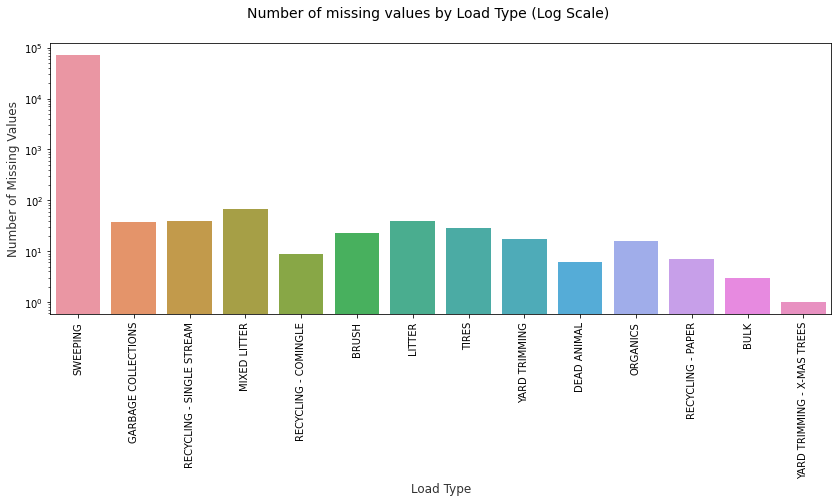

In [62]:
f, ax1 = plt.subplots(1, 1, figsize=(14, 5))
f.suptitle(f'Number of missing values by Load Type (Log Scale)', fontsize=14)

sns.countplot(x='Load Type', data=missing_data)
ax1.set_xlabel('Load Type',size = 12,alpha=0.8)
ax1.set_ylabel('Number of Missing Values',size = 12,alpha=0.8)
ax1.set_yscale('log')

plt.xticks(rotation=90)
plt.show()

* Outliers

Now, let's check if there are outliers.

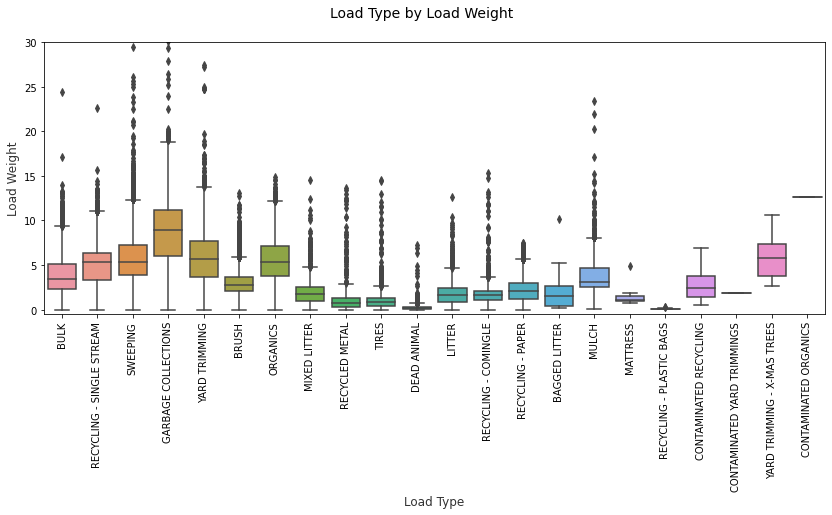

In [63]:
f, ax1 = plt.subplots(1, 1, figsize=(14, 5))
f.suptitle(f'Load Type by Load Weight', fontsize=14)

sns.boxplot(x='Load Type', y='Load Weight', data=waste, ax=ax1)
ax1.set_xlabel('Load Type',size = 12,alpha=0.8)
ax1.set_ylabel('Load Weight',size = 12,alpha=0.8)
ax1.set_ylim(-0.5,30)

plt.xticks(rotation=90)
plt.show()

**Observations:**

- Most of the outliers are upper outliers.
- There is one negagtive value of `Load Weight` in `RECYCLING - SINGLE STREAM` as we can see in the table below. Did they type it wrong or could that amount have been transfered elsewhere?

In [64]:
waste.groupby('Load Type')['Load Weight'].describe()

,count,mean,std,min,25%,50%,75%,max
Load Type,,,,,,,,
BAGGED LITTER,43.0,6.353733,30.412056,0.16,0.3500,1.520,2.5950,200.7805
BRUSH,39141.0,3.000468,1.228709,0.00,2.1300,2.750,3.6200,54.9400
BULK,40117.0,3.748596,2.025574,0.00,2.3400,3.460,5.1400,203.5110
CONTAMINATED ORGANICS,1.0,12.690000,NaN,12.69,12.6900,12.690,12.6900,12.6900
CONTAMINATED RECYCLING,8.0,2.850000,2.166749,0.49,1.3875,2.460,3.7875,6.9500
CONTAMINATED YARD TRIMMINGS,1.0,1.870000,NaN,1.87,1.8700,1.870,1.8700,1.8700
DEAD ANIMAL,6856.0,0.227256,0.297375,0.00,0.0500,0.130,0.3200,7.2700
GARBAGE COLLECTIONS,258395.0,8.541786,3.866808,0.00,6.0100,8.890,11.1900,781.4105
LITTER,1539.0,1.832186,1.317169,0.01,0.8800,1.680,2.3850,12.6300


**Where each type of waste is delivered ?**

In [65]:
group_by_route = (waste.groupby(['Load Type', 'Dropoff Site'],as_index=False)['Route Number'] 
                         .nunique() 
                         .dropna() 
                    )

group_by_route['Austin'] = 'Austin'
group_by_route.rename(columns={'Route Number':'Total Routes'},inplace=True)

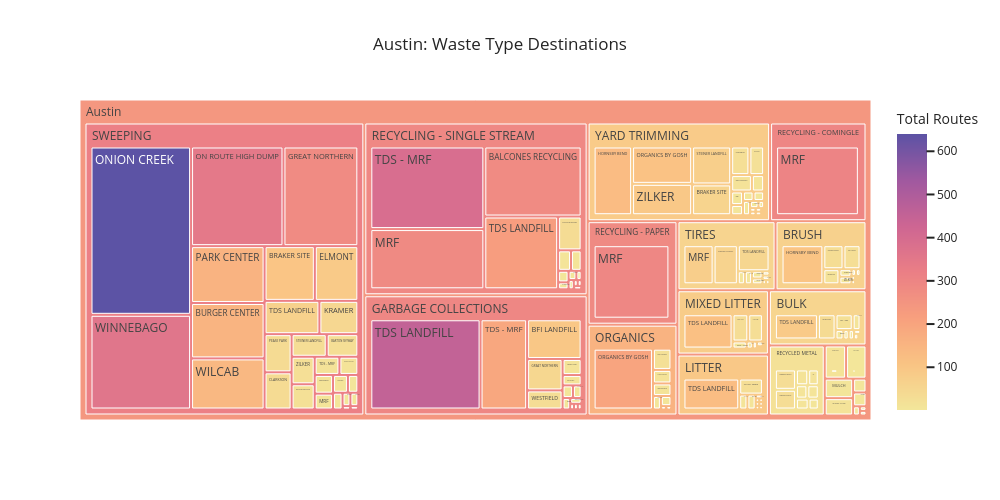

In [66]:
fig = px.treemap(group_by_route, path=['Austin', 'Load Type', 'Dropoff Site'], values='Total Routes',
                  color='Total Routes',
                  color_continuous_scale= px.colors.sequential.Sunset,
                  title='Austin: Waste Type Destinations')
fig.update_layout(template='seaborn')
fig.show("png",width=1000)

**What is the percentage of load weight each load type collected during the years ?**

There are many Load Types that changed the name or it was merged with another type. In this case, it is possible to notice that more than 99% of the Load Weight is represented only by 7 of 22 load types:

- BULK 
- GARBAGE COLLECTIONS 
- SWEEPING
- RECYCLING - SINGLE STREAM
- YARD TRIMMING
- ORGANICS
- BRUSH

In [67]:
percent = waste.copy()

percent['category'] = np.where(percent['Load Type'].isin(['BULK', 
                                                            'GARBAGE COLLECTIONS', 
                                                            'SWEEPING', 
                                                            'RECYCLING - SINGLE STREAM', 
                                                            'YARD TRIMMING', 
                                                            'ORGANICS',
                                                            'BRUSH']), 'main_categories', 'minor_categories')

percent = percent.groupby(['category', pd.Grouper(freq='Y')])['Load Weight'].sum().reset_index()

percent['year'] = percent['Report Date'].dt.year

percent['%'] = ((percent['Load Weight'] / percent.groupby(['year'])['Load Weight'].transform('sum')) * 100).round(4).abs()

percent = percent[percent['year'] > 2010]

In [13]:
percent.pivot_table('%', ['year'], 'category')

category,main_categories,minor_categories
year,,
2011,99.7109,0.2891
2012,99.6959,0.3041
2013,99.2764,0.7236
2014,99.5488,0.4512
2015,99.6517,0.3483
2016,99.3540,0.6460
2017,99.4786,0.5214
2018,99.7030,0.2970
2019,99.6771,0.3229


#### Time Series Analysis

**Observations:**

- We can see a clear pattern in the `BULK` and `YARD TRIMMING` until the beginning of COVID
- Some types of garbage collections have been suspended or reallocated, for example: `BAGGED LITTER` and `MULCH`
- Some have a very insignificant value compared to the largest collections: `YARD TRIMMING - X-MAS TREES`, `CONTAMINATED YARD TRIMMINGS`, `CONTAMINATED ORGANICS`, `CONTAMINATED RECYCLING`, `MATTRESS`, `MIXED LITTER`


#### Covid-19 impact


Some observations of the COVID-19 impact on the Waste Collection (the red vertical line represents the beginning of covid in the charts above):
- Even facing COVID pandemic, the `RECYCLING - SINGLE STREAM` has increased a little.
- The `CONTAMINATD RECYCLING`, had an increase right at the beggining of COVID, and it decreased over the time. Maybe, because some people started to recycle, and didn't know for sure how to do it?
- The `GARBAGE COLLECTIONS` also increased. People generate more waste while spending more time at home? 
- The `ORGANICS` increased significantly. People eat more while spending more time at home? People started to separate more organics?
- The other types in general decreased at the beginning of covid and rose again after some time. This can be explained because some services were suspended and after resumed (https://www.austintexas.gov/blog/recycling-austin-remains-resilient-during-covid-19).

In [14]:
waste_ts = waste[waste.index > '2011']  #take from 2011 onwards 

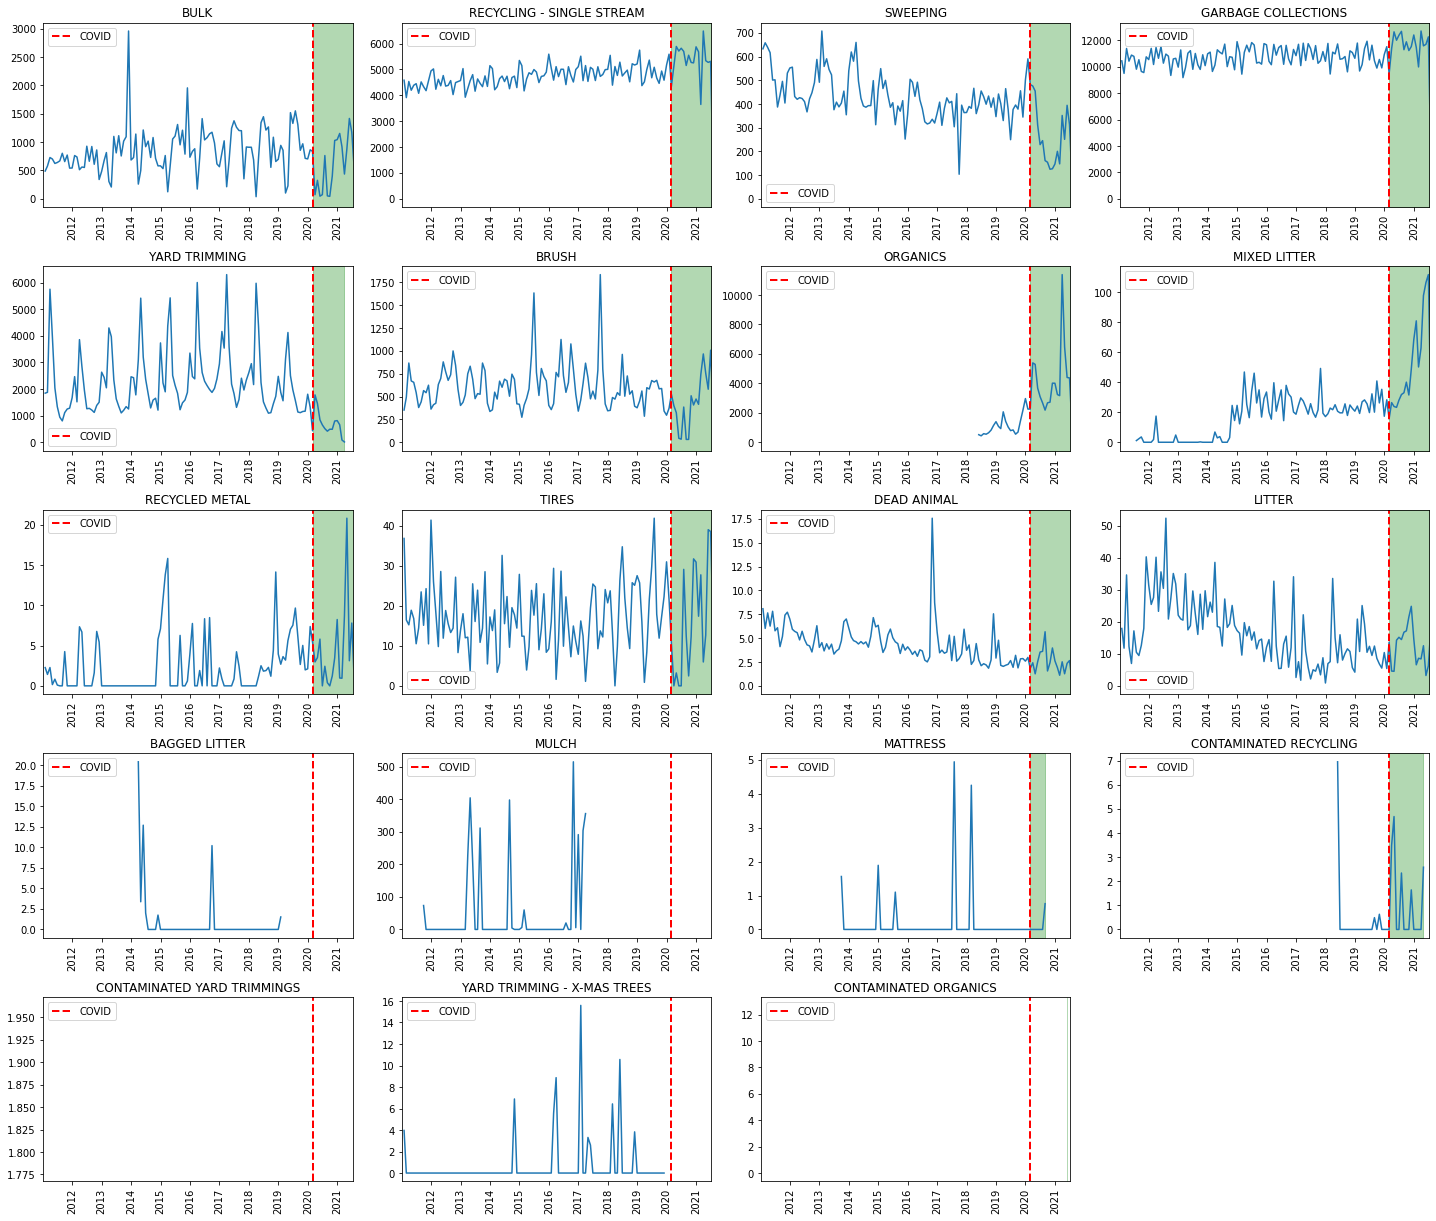

In [15]:
load_types = waste_ts['Load Type'].unique()
skip_plots = []
fig = plt.figure(figsize=(20,20))
for i, lt in enumerate(load_types):
    #resample the data to get monthly totals
    tmp = waste_ts[waste_ts['Load Type'] == lt]['Load Weight'].resample('M').sum()
    ax = fig.add_subplot(6, 4, i+1)
    plt.plot(tmp.index, tmp.values)
    plt.axvline(pd.to_datetime('2020-03'), color='r', linestyle='--', lw=2, label='COVID')
    plt.legend()
    plt.xticks(rotation=90)
    ax.set_title(lt)
    ax.fill_between(tmp.index, 0, 1, where=tmp.index >= pd.to_datetime('2020-02'),
                color='green', alpha=0.3, transform=ax.get_xaxis_transform())
    ax.set_xlim(waste_ts.index.min(), waste_ts.index.max())

fig.tight_layout()

#### Correlation between Waste Production and Waste Diversion Budget

Here, we are going to use the Annual Budgets dataset (see below in the References)

In [16]:
budget = pd.read_csv('./data/budget.csv', parse_dates=['date'])
budget['date'] = budget['date'].dt.year

To simplify the analysis, and considering that some types of `Load type` don't have very significant values, let's group the waste types into three larger groups:
- RECYCLING
    - RECYCLING - SINGLE STREAM
    - RECYCLED METAL
    - RECYCLING - PAPER
    - RECYCLING - PLASTIC BAGS
    - RECYCLING - COMINGLE
- ORGANICS
    - ORGANICS
    - YARD TRIMMING
    - YARD TRIMMING - X-MAS TREES
    - BRUSH
- DISPOSAL
    - GARBAGE COLLECTIONS
    - BULK
    - SWEEPING


In [68]:
def get_agg_group_fy(df, group_name, sub_groups):

    df = df[df['Load Type'].isin(sub_groups)].groupby([pd.Grouper(freq='A-SEP')]).sum()  # the city of Austin fiscal year begins on Oct. 1 and ends on Sept. 30 
    df['Load Type'] = group_name
    df = df.reset_index()

    return df

In [69]:
organics = get_agg_group_fy(waste, group_name='ORGANICS', sub_groups=['YARD TRIMMING', 'ORGANICS','BRUSH', 'YARD TRIMMING - X-MAS TREES'])

recycling = get_agg_group_fy(waste, group_name='RECYCLING', sub_groups=['RECYCLING - SINGLE STREAM', 
                                                                    'RECYCLING - COMINGLE', 
                                                                    'RECYCLING - PAPER',  
                                                                    'RECYCLED METAL',
                                                                    'RECYCLING - PLASTIC BAGS'])

disposal = get_agg_group_fy(waste, group_name='DISPOSAL', sub_groups=['BULK', 'GARBAGE COLLECTIONS', 'SWEEPING'])

waste_dataset = disposal.append([organics, recycling])
waste_dataset['year'] = waste_dataset['Report Date'].dt.year

In [70]:
waste_dataset = waste_dataset.merge(budget, left_on='year', right_on='date').drop(columns=['date'])   # merge waste and budget datasets

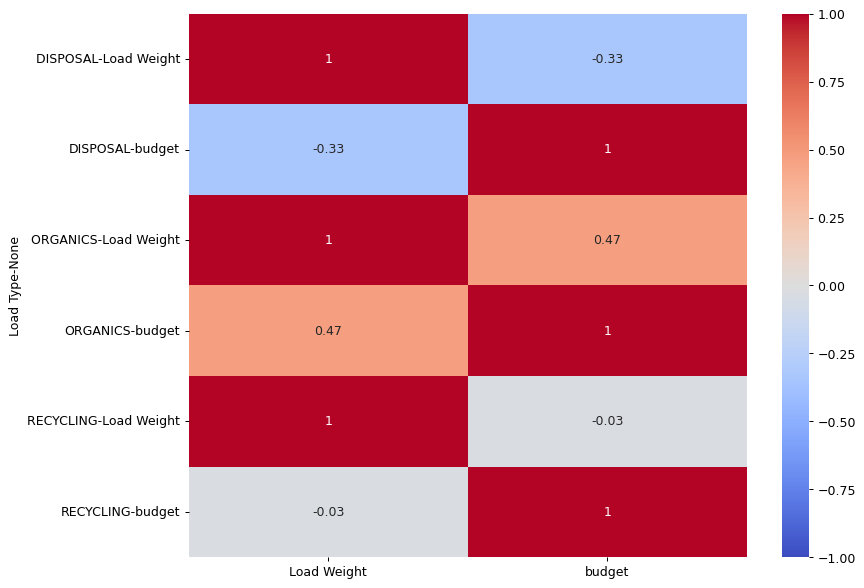

In [20]:
plt.figure(figsize=(10, 8), dpi= 90)
sns.heatmap(waste_dataset.groupby('Load Type')[['Load Weight','budget']].corr().round(2),
                annot=True, center=0, vmin=-1, vmax=1,
                cmap = "coolwarm")
plt.show()

**Observations:**

Using the Annual Budgets dataset, we could notice the correlation between the Waste Diversion Budget and the different types of waste (RECYCLING, ORGANICS and DISPOSAL). The correlation of the ORGANICS with the budget was 0.5, indicating that the organics grew with the increase of the budget. The correlation with Disposal was -0.33, which could indicate that there was a decrease in disposal production as the budget increased. Finally, the correlation with recycling was -0.03, indicating that the budget did not have a significant effect on recycling.

Let's plot one time series with the different types of waste (RECYCLING, ORGANICS AND DISPOSAL)

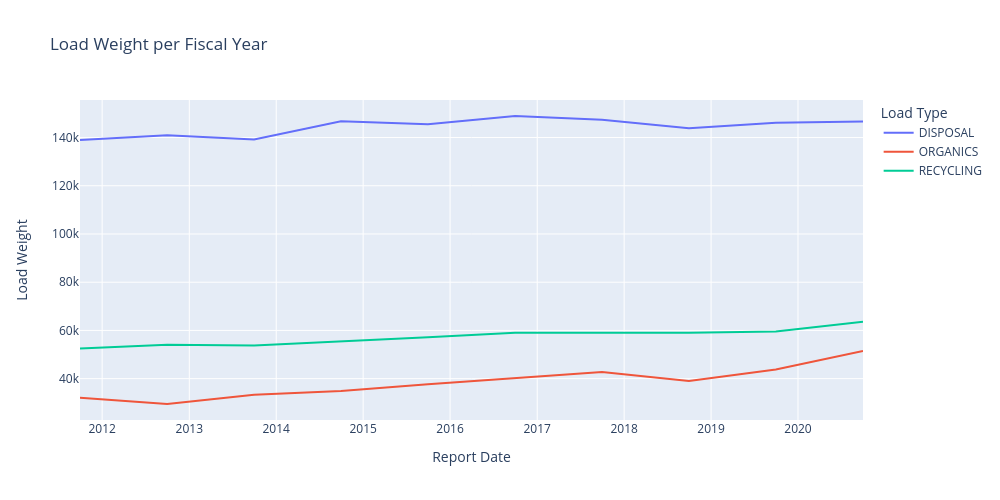

In [71]:
fig = px.line(waste_dataset[(waste_dataset['year']).between(2010,2020)], 
             y='Load Weight', 
             x='Report Date', 
             title='Load Weight per Fiscal Year',
             color='Load Type')
fig.show("png",width=1000)
# html = fig.to_html(full_html=True, include_plotlyjs=True)
# print(html)

#### Correlation between Waste Production and Retail Sales

Here, we are going to use the Sales tax & retail sales (see below in the References)

In [22]:
dateparse = lambda x: datetime.strptime(x, '%Y %b')
sales = pd.read_csv('./data/sales.csv', parse_dates=['date'], date_parser=dateparse)
sales['local_sales'] = sales['local_sales'].astype(str).str.replace('.', '').astype(int)

We'll going to use just the main `Load Types` to check this correlation:
- RECYCLING - SINGLE STREAM
- ORGANICS
- GARBAGE COLLECTIONS

In [23]:
def get_agg_group_month(df, group_name, sub_groups):
    df = df[df['Load Type'].isin(sub_groups)].groupby(pd.Grouper(freq='MS')).sum()
    df['Load Type'] = group_name
    df = df.reset_index()
    return df

In [24]:
recycling = get_agg_group_month(waste, group_name='RECYCLING - SINGLE STREAM', sub_groups=['RECYCLING - SINGLE STREAM'])
garbage = get_agg_group_month(waste, group_name='GARBAGE COLLECTIONS', sub_groups=['GARBAGE COLLECTIONS'])
organics = get_agg_group_month(waste, group_name='ORGANICS', sub_groups=['ORGANICS'])

waste_sales = recycling.append([garbage, organics])
waste_sales = waste_sales.merge(sales, left_on='Report Date', right_on='date')

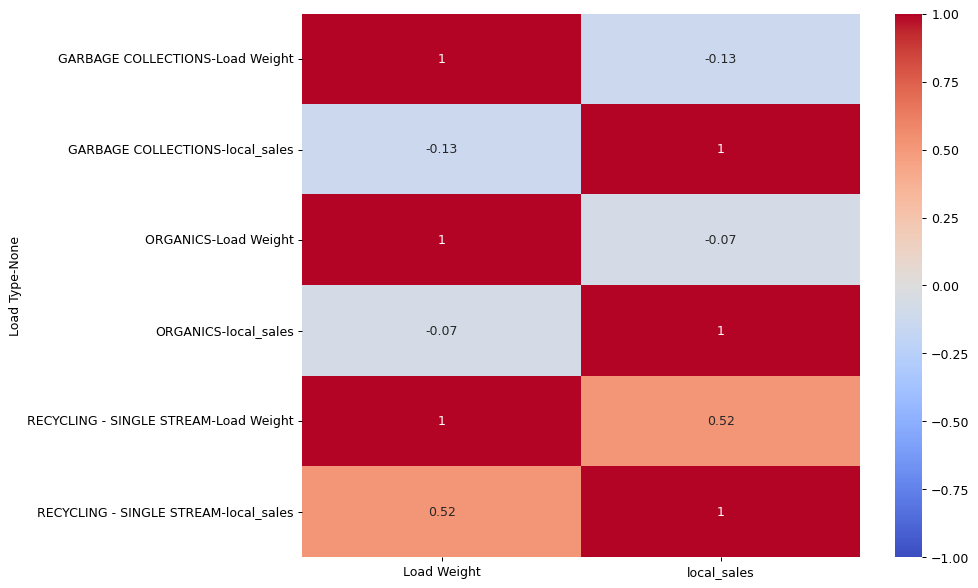

In [25]:
plt.figure(figsize=(10, 8), dpi= 90)
sns.heatmap(waste_sales.groupby('Load Type')[['Load Weight','local_sales']].corr().round(2),
                annot=True, center=0, vmin=-1, vmax=1,
                cmap = "coolwarm")
plt.show()

**Observations:**
- The correlation between the `GARBAGE COLLECTIONS` with `local_sales` is weak
- The correlation between the `ORGANICS` with `local_sales` is also weak
- The correlation between the `RECYCLING - SINGLE STREAM` with `local_sales` is moderate.

####  3 - <span style="color:blue">Austin Resource Recovery Master Plan Goals</span>  <a class="anchor" id="third-bullet"></a>

The City of Austin is committed to a zero waste goal to reduce the amount of trash sent to landfills by 90% by the year 2040. Zero waste puts a greater emphasis on reducing consumption, cutting down on trash at the source while aiming for no waste to be burned or buried. The goal is to divert reusable resources from landfills and incinerators to activities like recycling and composting.

In this chapter we are going to verify which of the main goals were accomplished, and investigate what factors may be avoiding to reach theirs goals

**Is the Divertion Rate Targets for 2015 and 2020 were accomplished ?**

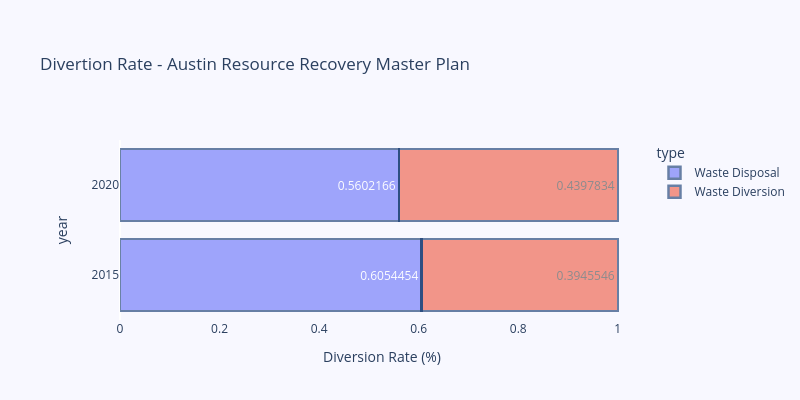

In [27]:
waste_rate_dataset = waste_dataset.copy()
waste_rate_dataset['type'] = np.where(waste_rate_dataset['Load Type'] == 'DISPOSAL', 'Waste Disposal', 'Waste Diversion')
waste_rate_dataset = waste_rate_dataset.groupby(['year', 'type']).sum().reset_index()
waste_rate_dataset['Diversion Rate (%)'] = waste_rate_dataset['Load Weight'] / waste_rate_dataset.groupby(['year'])['Load Weight'].transform('sum')
waste_rate_dataset = waste_rate_dataset[(waste_rate_dataset['year'].isin([2015, 2020]))] 
waste_rate_dataset['year'] = waste_rate_dataset.year.astype(str)

fig = px.bar(waste_rate_dataset,
             x="Diversion Rate (%)", y="year", color='type', orientation='h',
             text_auto= True,
             #hover_data=["tip", "size"],
             height=400,
             title='Divertion Rate - Austin Resource Recovery Master Plan')

fig.update_traces( marker_line_color='rgb(8,48,107)',
                  marker_line_width=2.5, opacity=0.6)


fig.update_layout(xaxis_rangeslider_visible=False, 
    xaxis=dict(
        showticklabels=True,
        showgrid=False,
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=True,
        showticklabels=True,
        gridwidth=0.5,
        gridcolor='lightgray'

    ),
    autosize=True,
    showlegend=True,
    barmode='stack',
    paper_bgcolor='rgb(248, 248, 255)',
    plot_bgcolor='rgb(248, 248, 255)',
    margin=dict(l=120, r=10, t=140, b=80),
)

fig.show("png",width=800)
# html = fig.to_html(full_html=True, include_plotlyjs=True)
# print(html)

**Is the Residential Organics Collection Targets for 2015 and 2020 were accomplished ?**

According to the table from Austin Master Plan report, the target for organics collection for 2015 and 2020 are 30K and 50K respectively.

In [29]:
organics_target = waste_dataset.copy()
organics_target = organics_target[(organics_target['year'].isin([2015,2020])) & (organics_target['Load Type'].isin(['ORGANICS']))][['year', 'Load Weight']]
organics_target['type'] = 'actual'
organics_target.loc[len(organics_target.index)] = [2015, 30000, 'Expected'] 
organics_target.loc[len(organics_target.index)] = [2020, 50000, 'Expected'] 
organics_target['year'] = organics_target['year'].astype(str)

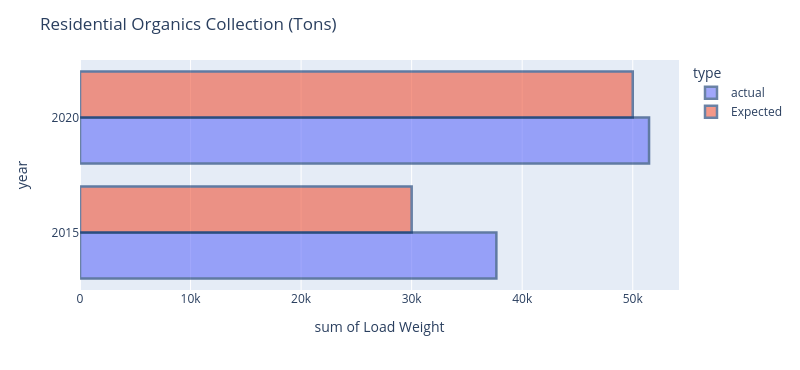

In [30]:
fig = px.histogram(organics_target, x="Load Weight", y="year",
             color='type', barmode='group',
             height=370, #text_auto=True, 
             orientation='h',
             )

fig.update_traces( marker_line_color='rgb(8,48,107)',
                  marker_line_width=2.5, opacity=0.6)

fig.update_layout(title_text='Residential Organics Collection (Tons)')


fig.show("png",width=800)
# html = fig.to_html(full_html=True, include_plotlyjs=True)
# print(html)

**Is the Single Stream Recycling Targets for 2015 and 2020 were accomplished ?**

According to the table from Austin Master Plan report, the target for organics collection for 2015 and 2020 are 75k and 80K respectively.

In [31]:
recycling_target = waste_dataset.copy()
recycling_target = recycling_target[(recycling_target['year'].isin([2015,2020])) & (recycling_target['Load Type'].isin(['RECYCLING']))][['year', 'Load Weight']]
recycling_target['type'] = 'actual'
recycling_target.loc[len(recycling_target.index)] = [2015, 75000, 'Expected'] 
recycling_target.loc[len(recycling_target.index)] = [2020, 80000, 'Expected'] 
recycling_target['year'] = recycling_target['year'].astype(str)

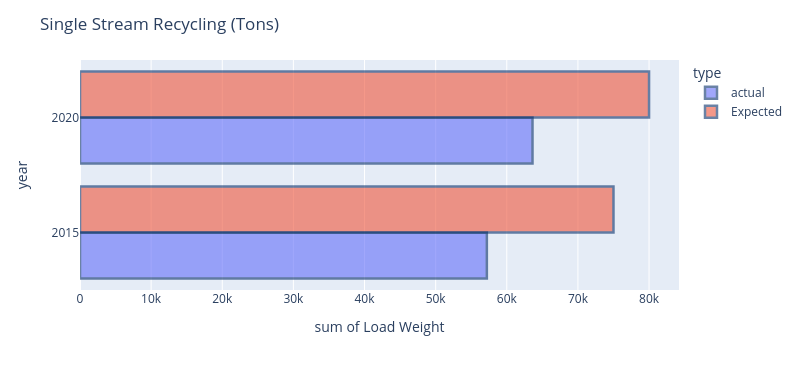

In [33]:
fig = px.histogram(recycling_target, x="Load Weight", y="year",
             color='type', barmode='group',
             height=370, #text_auto=True, 
             orientation='h',
             )

fig.update_traces( marker_line_color='rgb(8,48,107)',
                  marker_line_width=2.5, opacity=0.6)

fig.update_layout(title_text='Single Stream Recycling (Tons)')


fig.show("png",width=800)
# html = fig.to_html(full_html=True, include_plotlyjs=True)
# print(html)

####   4 - <span style="color:blue">Forecasting Model</span>  <a class="anchor" id="fourth-bullet"></a>

We already indentified that recycling didn't reach the proposed "Master Plan Target". In that case, we are going to create a model to predict how many years it will take to this target be reached.

In [33]:
model_data = pd.read_csv('./data/waste.csv', parse_dates=['Report Date'], index_col=['Report Date']).drop(columns=['Load ID', 'Load Time'])
model_data['Load Weight'] = model_data['Load Weight'] / 2000   # transform pounds to tons
model_data = model_data[(model_data.index >= '2008-10-01') & (model_data.index < '2020-09-30')]

In [34]:
model_data = model_data[model_data['Load Type'].isin(['RECYCLING - SINGLE STREAM'])].groupby([pd.Grouper(freq='A-SEP')]).sum()  # the city of Austin fiscal year begins on Oct. 1 and ends on Sept. 30 
model_data['Load Type'] = 'RECYCLING'
model_data = model_data.reset_index()
model_data = model_data[model_data['Load Type'].isin(['RECYCLING'])]
model_data.rename(columns={'Report Date':'ds', 'Load Weight':'y',},inplace=True)
model_data = model_data[['ds', 'y']].copy()

In [35]:
model_data

,ds,y
0,2009-09-30,49648.6800
1,2010-09-30,52301.7100
2,2011-09-30,52467.4240
3,2012-09-30,54014.3765
4,2013-09-30,53757.5630
5,2014-09-30,55411.9775
6,2015-09-30,57137.1195
7,2016-09-30,58999.7265
8,2017-09-30,58878.5175
9,2018-09-30,59006.5790


In [36]:
m = NeuralProphet()
metrics = m.fit(model_data, freq='A-SEP')

INFO - (NP.df_utils._infer_frequency) - Major frequency Y corresponds to 91.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - A-SEP
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 12
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 1000


  0%|          | 0/101 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.09E-02, min: 2.40E+00


  0%|          | 0/101 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.09E-02, min: 2.40E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.57E-02
Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:09<00:00, 104.36it/s, SmoothL1Loss=0.000632, MAE=403, RMSE=487, RegLoss=0]


In [ ]:
future = m.make_future_dataframe(df=model_data, periods=8, n_historic_predictions=True)
forecast = m.predict(df=future)

INFO - (NP.df_utils._infer_frequency) - Major frequency Y corresponds to 91.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - A-SEP
INFO - (NP.df_utils._infer_frequency) - Major frequency Y corresponds to 95.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - A-SEP
INFO - (NP.df_utils._infer_frequency) - Major frequency Y corresponds to 95.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - A-SEP


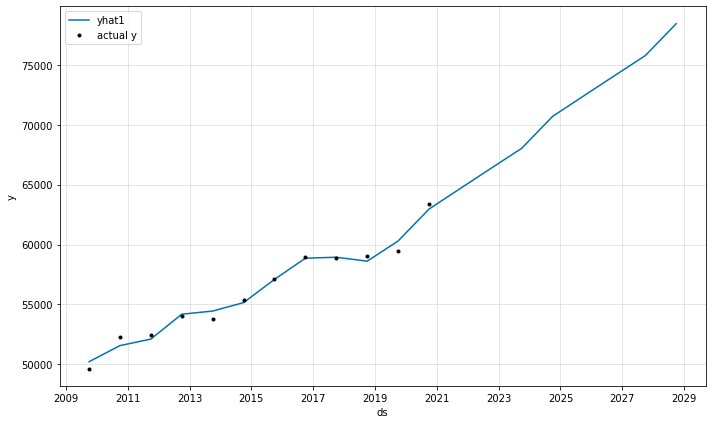

In [ ]:
fig_forecast = m.plot(forecast)

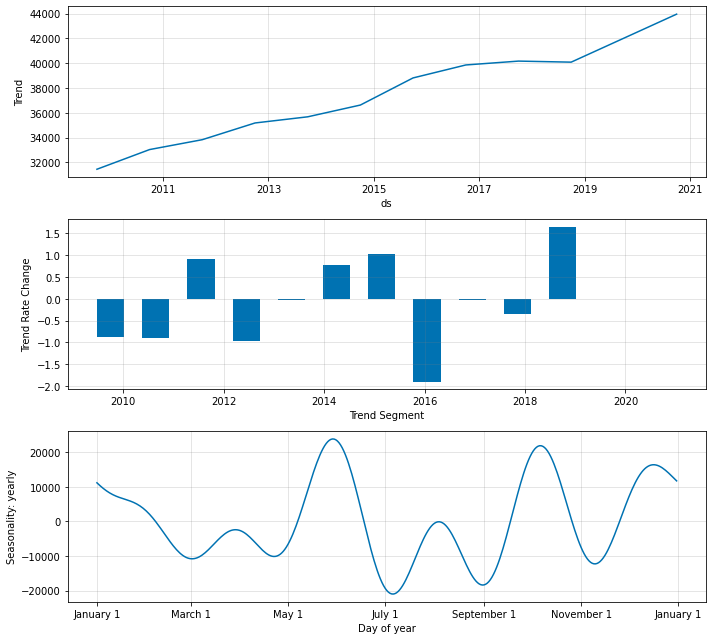

In [ ]:
fig_param = m.plot_parameters()

####  5 - <span style="color:blue">Product proposal</span>  <a class="anchor" id="fifth-bullet"></a>

Our product proposal is a ChatBot App that helps the citizens to identify if the waste can be recycled or not.
Citizens of Austin would use the ChatBot App in their everyday life to understand if the waste that they produce can be recycled or not. This can be an easy and interactive way for people to learn how to recycle.

In this chapter we provided an example of inference that will be used by the chatbot app.

The model classifies whether the image is Recyclacle or Organic:
- R: Recyclable
- O: Organic

In [ ]:
url = 'https://img.kalunga.com.br/fotosdeprodutos/145110z.jpg'
response = requests.get(url, stream=True)
with open('img.png', 'wb') as out_file:
    shutil.copyfileobj(response.raw, out_file)
del response

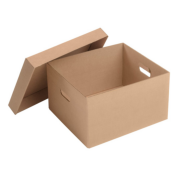

In [ ]:
img = open_image('img.png')
img.show()

In [ ]:
learn = load_learner('', './data/model.pkl')
pred_class, pred_idx, outputs = learn.predict(img)
print(str(pred_class))

R


####   6 - <span style="color:blue">Exploratory spatial data analysis (ESDA)</span>  <a class="anchor" id="sixth-bullet"></a>

Since we want to implement a chatbot application, we need to find which Austin area we should focus our efforts. In this chapter we are going to explore  Value-by-alpha maps which is a bivariate choropleth technique where we consider two variables that affect each other. This is useful to find regions where the recycling weight is low and the waste disposal is high. It is also possible to find regions where population is high and recycling weight is low.


In [41]:
def get_weight_data(df, route):

    map_weight = (df[(df['Route Type'] == route)]
        .groupby(['Route Number', 'year'])['Load Weight'].sum()).reset_index(name='Routes Count')

    map_weight = map_weight[map_weight['year'] == 2020]
    
    return map_weight

In [42]:
def get_route_values(counties, route):

    zipcode = []
    routes = []

    for i in range(len(counties['features'])):
        code = counties['features'][i]['properties']['GEOID10'].strip()
        for j in [k.strip() for k in (counties['features'][i]['properties'][route]).split(",")]:
            zipcode.append(code)
            routes.append(j)

    return pd.DataFrame({'zip': zipcode, 'routes': routes})

In [45]:
def merge_dataset(df_map, map_weight):
    dataset = df_map.merge(map_weight, left_on='routes', right_on='Route Number', how='left').dropna()
    dataset.drop(columns='year', inplace=True)
    dataset = dataset.groupby('zip')[['Routes Count']].agg(weight=('Routes Count', 'sum')).reset_index()
    
    return dataset

In [46]:
import json
with open('./data/austin_zip_geojson.json') as response:

    counties = json.load(response)

In [47]:
maps_dataset = waste.copy()
maps_dataset['year'] = maps_dataset.index.year

In [48]:
df_map_recy = get_route_values(counties, route='recycle_rt')
map_weight_recy = get_weight_data(maps_dataset, route='RECYCLING - SINGLE STREAM')
dataset_recy = merge_dataset(df_map_recy, map_weight_recy)

df_map_garb = get_route_values(counties, route='rec_rt')  
map_weight_garb = get_weight_data(maps_dataset, route='GARBAGE COLLECTION')
dataset_garb = merge_dataset(df_map_garb, map_weight_garb)

In [49]:
dataset = dataset_recy.merge(dataset_garb, on='zip', suffixes=('_recy', '_garb'))
gdf = gpd.read_file('./data/austin_zip_geojson.json')
gdf = gdf.merge(dataset, how='left', left_on='GEOID10', right_on='zip')

We are going to find which zip-code contains high waste disposal collected and low single stream recycling collected. The dark gray color indicates this pattern.

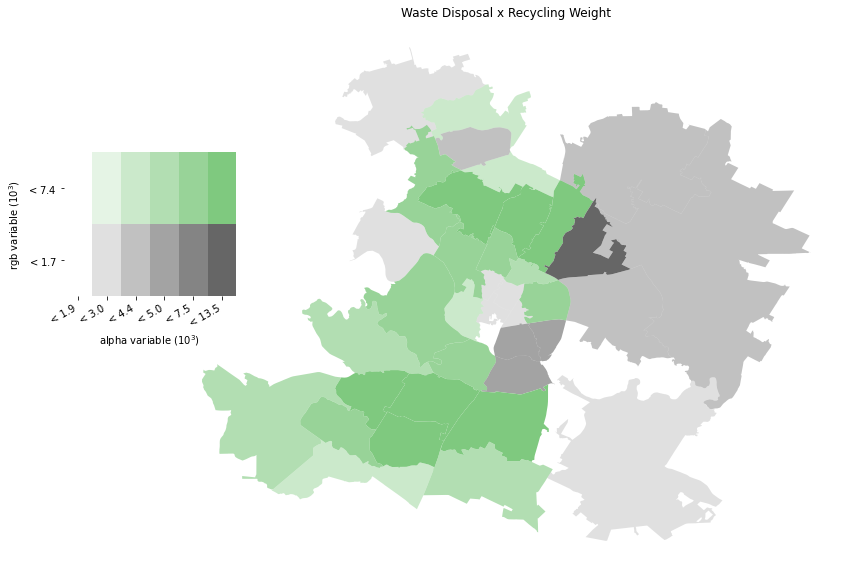

In [57]:
fig, ax = plt.subplots(figsize=(12,10))

plt.title('Waste Disposal x Recycling Weight')

vba_choropleth(
     gdf['weight_recy'].values, 
     gdf['weight_garb'].values, 
     gdf, 
     rgb_mapclassify=dict(classifier='quantiles', k=2),
     alpha_mapclassify=dict(classifier='quantiles', k=6),
     cmap='Accent_r', #Accent_r
     ax=ax,
     revert_alpha=False,
     legend = True )

plt.show()

Let`s do the same analysis comparing in this case, population of 2019 against anual weight collected in recycling. The dark brown area indicates High population with low single stream recycling collected.

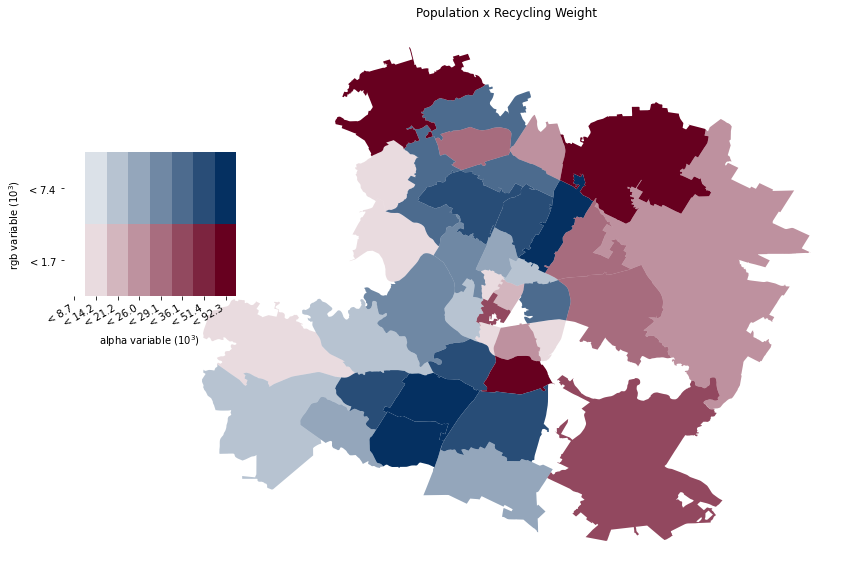

In [56]:
fig, ax = plt.subplots(figsize=(12,10))

plt.title('Population x Recycling Weight')

vba_choropleth(
     gdf['weight_recy'].values, 
     gdf['pop_2019'].values, 
     gdf, 
     rgb_mapclassify=dict(classifier='quantiles', k=2),
     alpha_mapclassify=dict(classifier='quantiles', k=8),
     cmap='RdBu', 
     ax=ax,
     revert_alpha=False,
     legend = True 
)




plt.show()

####  7 - <span style="color:blue">Conclusion</span>  <a class="anchor" id="seventh-bullet"></a>

Using the provided dataset, it was possible to verify the waste disposal system behavior in Austin. It was possible to notice the city effort to implement the Resource Recovery Master Plan Goals. 

- We realized that diversion rate goal was affected especially by the recycling target not be accomplished and COVID19 which increased waste production, probably because people spent more time at home. 

- Using the Annual Budgets dataset, we could notice the correlation between the Waste Diversion Budget and the different types of waste (RECYCLING, ORGANICS AND DISPOSAL). The correlation of the ORGANICS with the budget was 0.5, indicating that the organics grew with the increase of the budget. The correlation with Disposal was -0.33, which could indicate that there was a decrease in disposal production as the budget increased. Finally, the correlation with recycling was -0.03, indicating that the recycling did not have a strong dependence on budget.

This indicates that more actions is necessary to motivate residents to recycle. Austin Resource Recovery [[1](https://www.kvue.com/article/news/20-of-austins-recycling-is-contaminated-i-was-totally-dumbfounded/269-cdd66025-9b65-49e4-a7a6-5652d2f956a6)] indicates that 20% of Austin’s recycling is contaminated, and that residents don’t know what can really go into the recycling bins [[2](https://www.kxan.com/news/recycle-or-trash-study-finds-austins-recycling-rules-confusing)]. Based on that, we proposed a chatbot solution which will help residents to classify which garbage is recycable, in order to motive them to start recycling.





## 🖼️ Visualisations



#### Austin: Distribution by Load Weight




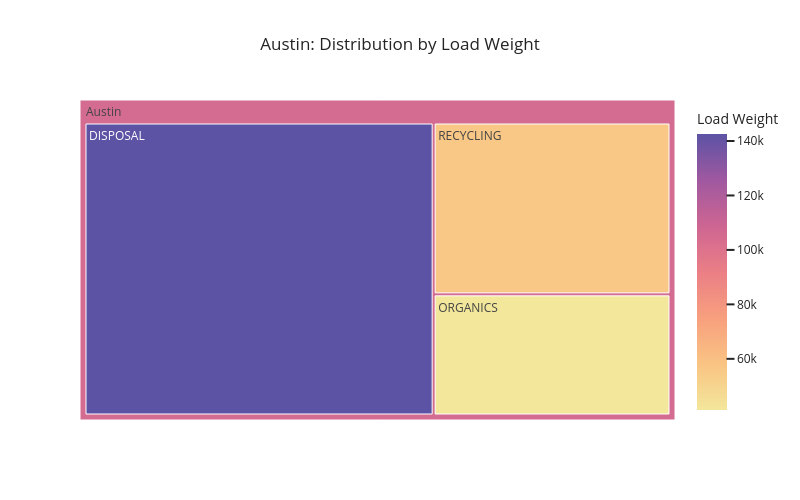

In [35]:
waste_dataset['Austin'] = 'Austin'

fig = px.treemap(waste_dataset, path=['Austin', 'Load Type'], values='Load Weight',
                  color='Load Weight',
                  color_continuous_scale= px.colors.sequential.Sunset,
                  title='Austin: Distribution by Load Weight')
fig.update_layout(template='seaborn')
fig.show("png", width=800)
# html = fig.to_html(full_html=True, include_plotlyjs=True)
# print(html)

#### Load Weight Percentage by Load Type

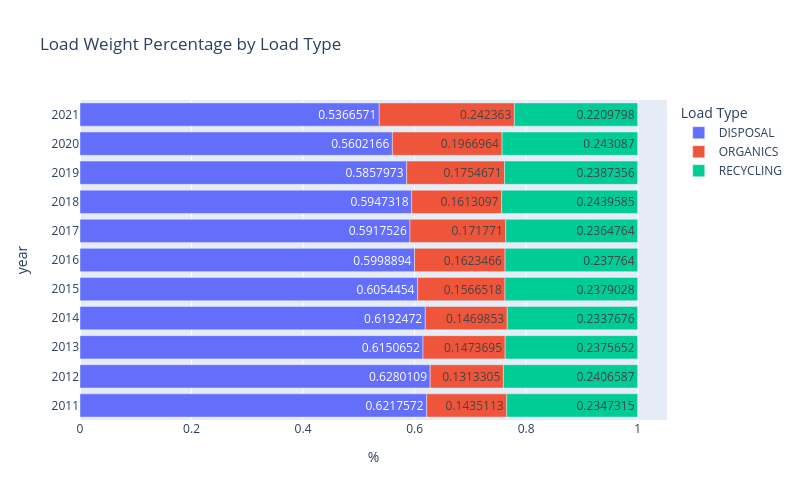

In [36]:
waste_dataset['%'] = waste_dataset['Load Weight'] / waste_dataset.groupby(['year'])['Load Weight'].transform('sum')


fig = px.bar(waste_dataset,
             x="%", y="year", color='Load Type', orientation='h',
             text_auto= True,
             title='Load Weight Percentage by Load Type')

fig.update_layout(  yaxis = dict(
tickmode = 'linear'
))

fig.show("png", width=800)
# html = fig.to_html(full_html=True, include_plotlyjs=True)
# print(html)

####  8 - <span style="color:blue">References</span>  <a class="anchor" id="eighth-bullet"></a>

List all of the external links (even if they are already linked above), such as external datasets, papers, blog posts, code repositories and any other materials.

**External Datasets:**
- Annual Budgets (from [Austin Finance Online](https://financeonline.austintexas.gov/afo/afo_content.cfm?s=1&p=57)). Contains pdf reports that have the waste diversion budget per year.
- Sales tax & retail sales (from [Texas Comptroller of Public Accounts](https://cdn1.austinchamber.com/%20ed/files/ecoind/SalesTaxAustin.xlsx?_ga=2.237722496.12576855.1647971362-1845832613.1647971362)). Contains an excel file that have the Local Sales and Use Tax Allocations of Austin per month.
- Waste Classification image data (from [Kaggle](https://www.kaggle.com/techsash/waste-classification-data))
- Recycling Routes (from [koordinates](https://koordinates.com/layer/101499-city-of-austin-texas-recycling-routes/)) 
- Austin Population by zip-code (from [koordinates](https://www.city-data.com/city/Austin-Texas.html)) 



## ⏭️ Appendix
Add here any code, images or text that you still find relevant, but that was too long to include in the main report. This section is optional.


In [99]:
import json
with open('./data/recycle_rt.geojson') as response:

    counties = json.load(response)

In [100]:
map_freq = waste.copy()
map_freq['year'] = map_freq.index.year
map_freq = (map_freq[(map_freq['Load Type'] == 'RECYCLING - SINGLE STREAM')]
    .groupby(['Route Number', 'year'])['Load Weight'].sum()).reset_index(name='Routes Count')
map_freq = map_freq.reset_index()
map_freq = map_freq[map_freq['year'] == 2020]


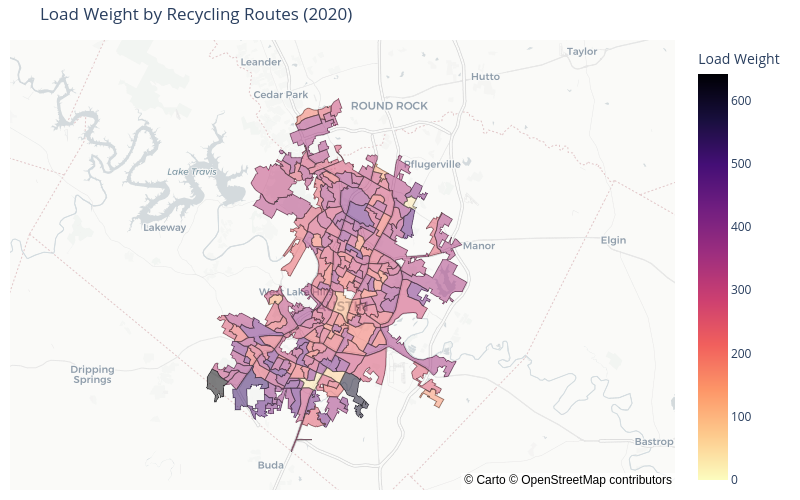

In [110]:
fig = px.choropleth_mapbox(map_freq, geojson=counties, locations='Route Number', color=map_freq['Routes Count'],
                           color_continuous_scale="magma_r",
                           title='Load Weight by Recycling Routes (2020)',
                           mapbox_style="carto-positron",
                           zoom=9.0, 
                           center = {"lat": 30.32, "lon": -97.7431},
                           opacity=0.5,
                           animation_frame='year',
                           labels={'Routes Count':'Load Weight'},
                           featureidkey="properties.rec_rt"
                          )
                          
fig.update_layout(margin={"r":10,"t":40,"l":10,"b":10})
fig.show("png", width=800)


In [75]:
def calmap(dataset, title, scale):
    years = dataset.year.unique()
    fig = make_subplots(rows=len(years),cols=1,shared_xaxes=True,vertical_spacing=0.005)
    r=1
    for year in years:
        data = dataset[dataset['year']==year]
        #data = introduce_nulls(data)
        fig.add_trace(go.Heatmap(
            z=data['Load Weight'],
            x=data.week,
            y=data.day_name,
            hovertext=data['Report Date'].dt.date,
            coloraxis = "coloraxis",name=str(year),
        ),r,1)
        fig.update_yaxes(title_text=str(year),tickfont=dict(size=5),row = r,col = 1)
        r+=1
    fig.update_xaxes(range=[1,53],tickfont=dict(size=10), nticks=53)
    fig.update_layout(coloraxis = {'colorscale':scale})
    fig.update_layout(template='seaborn', title=title)
    fig.update_layout(
                    autosize=False,
                    width=1200,
                    height=1000,)

    return fig

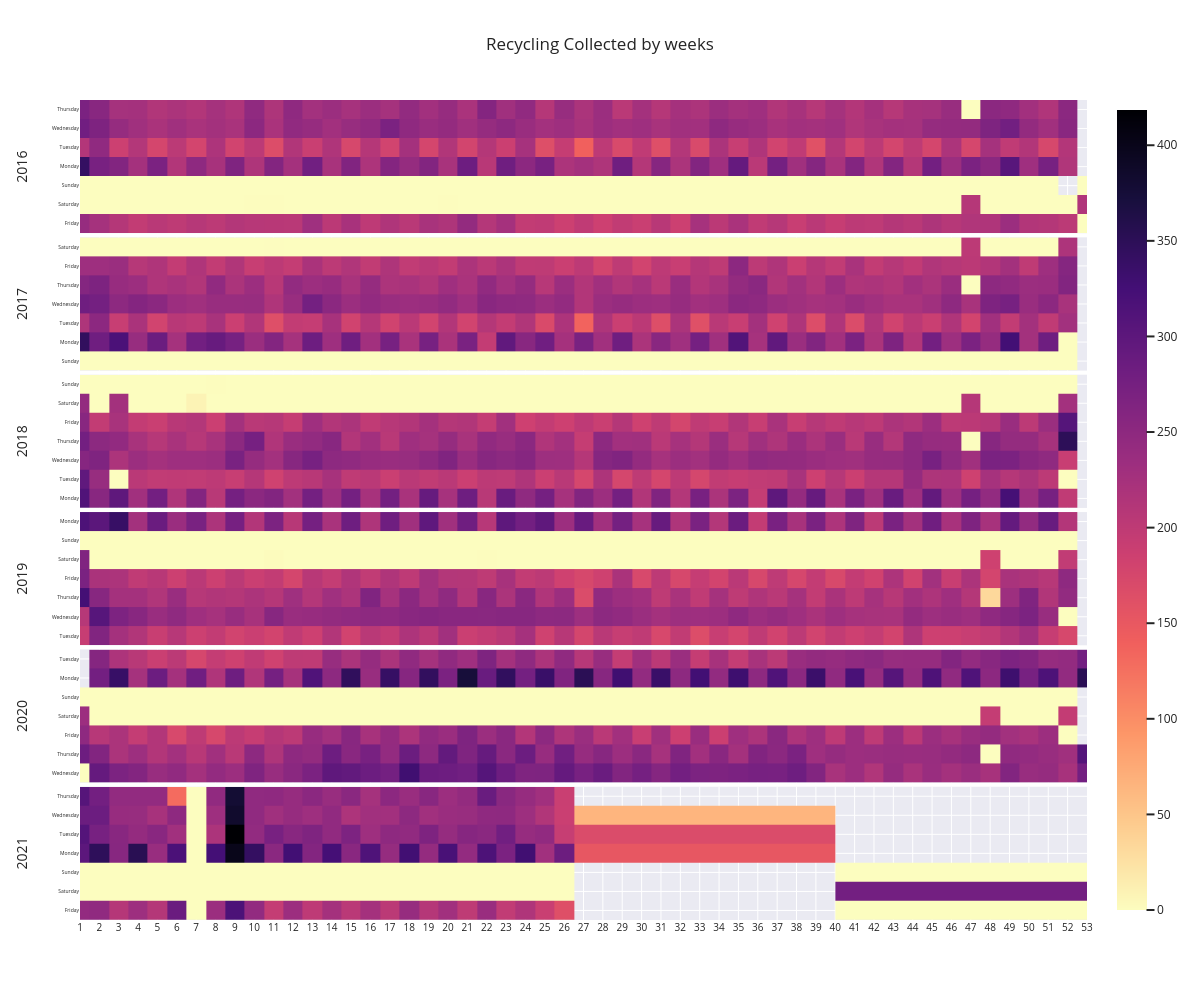

In [86]:
dropoff_freq = waste.copy()
dropoff_freq = dropoff_freq[(dropoff_freq['Load Type'] == 'RECYCLING - SINGLE STREAM') ].groupby([pd.Grouper(freq='1D')]).sum()
dropoff_freq = dropoff_freq.reset_index()
dropoff_freq['year'] = dropoff_freq['Report Date'].dt.year
dropoff_freq['week'] = dropoff_freq['Report Date'].dt.weekofyear
dropoff_freq['day_name'] = dropoff_freq['Report Date'].dt.day_name()
dropoff_freq = dropoff_freq[dropoff_freq['year'] > 2015]
x = calmap(dropoff_freq, 'Recycling Collected by weeks', 'magma_r')
x.show("png")